# Best practices workflow for preprocessing of single-cell RNA-seq data

This notebook presents a best practice workflow for the preprocessing of single-cell RNA-seq da'ta. It is a slightly modified version of the [single-cell-tutorial](https://github.com/theislab/single-cell-tutorial) as presented in [Best practices in single-cell RNA-seq analysis: a tutorial](https://www.embopress.org/doi/10.15252/msb.20188746) by Luecken and Theis (2019).

The `scanpy` api gives access to all tools availalbe via the `scanpy` platform. `Numpy` and `scipy` are useful scientific computing libraries that are used by `scanpy`, and `pandas` is used to load in the data. `Pandas` is also the basis of the data structures used in `scanpy` (the `Anndata` module). `Matplotlib` and `seaborn` are used for plotting. R libraries that are used in this tutorial include `scran` for preprocessing

## Table of contents:

  * <a href=#Reading>1 Loading the data</a>
  * <a href=#Preprocessing>2 Pre-processing and visualization</a>
    * <a href=#QC>2.1 Quality Control</a>
    * <a href=#Normalization>2.2 Normalization</a> 
    * <a href=#Batch>2.3 Batch correction</a>
    * <a href=#HVG>2.4 Highly variable genes</a>
    * <a href=#Visualization>2.5 Visualization</a>
    * <a href=#CC>2.6 Cell cycle scoring</a>
  * <a href=#Downstream>3 Downstream analysis</a>
    * <a href=#Clustering>3.1 Clustering</a>
    * <a href=#Markers>3.2 Marker genes & cluster annotation</a>
    * <a href=#PAGA>3.3 Partition-based graph abstraction</a>
  * <a href=#Write>4 Save results</a>
  * <a href=#Summary>5 Summary</a>

## The scope of this notebook

This notebook is intented to give the user a **first impression of the data**. Several visualizations of the preprocessing steps will help the user to determine the quality of the data and to find the best filter settings.

<< Due to the generality of this notebook, **the analysis parameters will not be optimal** in the first run! >>

*To obtain an optimal result, gene counts should be non-normalized.*

## Import the libraries

In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gc

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects import pandas2ri
import anndata2ri

# Ignore Python warning messages
import warnings
warnings.filterwarnings('ignore')

# to output data in sparse format
from scipy import sparse as scs

# import fastgenomics
import fgread

# increase figure quality
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [2]:
# Ignore R warning messages
#Note: this can be commented out to get more verbose R output
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# Automatically convert rpy2 outputs to pandas dataframes
pandas2ri.activate()
anndata2ri.activate()
%load_ext rpy2.ipython

plt.rcParams['figure.figsize'] = (8, 8)  #rescale figures
sc.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
sc.logging.print_versions()

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [3]:
%%R
# Load libraries from correct lib Paths for my environment - ignore this!
.libPaths(.libPaths()[c(3,2,1)])

# Load all the R libraries we will be using in the notebook
library(scran)
library(RColorBrewer)
library(gam)
library(ggplot2)
library(plyr)

# FASTGenomics data loading<a id="Reading"></a>
As the data set is hosted on FASTgenomics in the AnnData format, the original data loading is not needed here. We only use this one cell to read the data.

In [4]:
dsets = fgread.get_datasets()
adata = fgread.read_dataset(dsets[1])
try:
    adata.X = adata.X.toarray()
except:
    print('adata.X is already a dense array.')
gc.collect()  # free up memory

Loading dataset "Haber2018 GSE92332" in format "AnnData" from directory "/fastgenomics/data/dataset_0001".
adata.X is already a dense array.


49106

**Test if data can be grouped into samples**

Some datasets (e.g. Haber et al., 2017) comprise data taken from different regions or from different tissue samples. These data can be analyzed by group. If no such samples are present, we analyze the complete dataset without grouping.

In [5]:
has_samples = False
try:
    tmp = adata.obs['sample']
    tmp = adata.obs['sample'].value_counts()
    if (tmp>1).sum() > 0:
        has_samples = True
        print('Dataset has samples and can be grouped.')
    else:
        raise ValueError
except:
    print('No sample groups detected.')

Dataset has samples and can be grouped.


Once the data is loaded, we test whether we have the expected number of cells.

In [6]:
# Annotate the data sets
if has_samples:
    print(adata.obs['sample'].value_counts())

Jej_M2    2668
Il_M1     2466
Duo_M1    2348
Duo_M2    2206
Il_M2     1837
Jej_M1    1828
Name: sample, dtype: int64


In [7]:
# Checking the total size of the data set
N_cells, N_genes = adata.shape
print('Dataset contains {} cells and {} genes.'.format(N_cells, N_genes))

Dataset contains 13353 cells and 27998 genes.


# Pre-processing and visualization<a id="Preprocessing"></a>

## Quality control<a id="QC"></a>

Data quality control can be split into cell QC and gene QC. Typical quality measures for assessing the quality of a cell include the number of molecule counts (UMIs), the number of expressed genes, and the fraction of counts that are mitochondrial. A high fraction of mitochondrial reads being picked up can indicate cell stress, as there is a low proportion of nuclear mRNA in the cell. It should be noted that high mitochondrial RNA fractions can also be biological signals indicating elevated respiration.

In [8]:
# Quality control - calculate QC covariates
adata.obs['n_counts'] = adata.X.sum(1)
adata.obs['log_counts'] = np.log(adata.obs['n_counts'])
adata.obs['n_genes'] = (adata.X > 0).sum(1)

### Check if mitochondrial cells are present

In [9]:
has_mt = False #  | lower_case -> mt- mt_
mt_gene_mask = [gene.lower().startswith('mt-') for gene in adata.var_names]
if np.sum(mt_gene_mask) > 0:
    adata.obs['mt_frac'] = np.squeeze(adata.X[:, mt_gene_mask].sum(1)) / adata.obs['n_counts']
    if adata.obs['mt_frac'].sum() > 0:
        has_mt = True
else:
    adata.obs['mt_frac'] = None

print('Mitochondrial cells detected? -', str(has_mt))

Mitochondrial cells detected? - True


... storing 'fg_title' as categorical


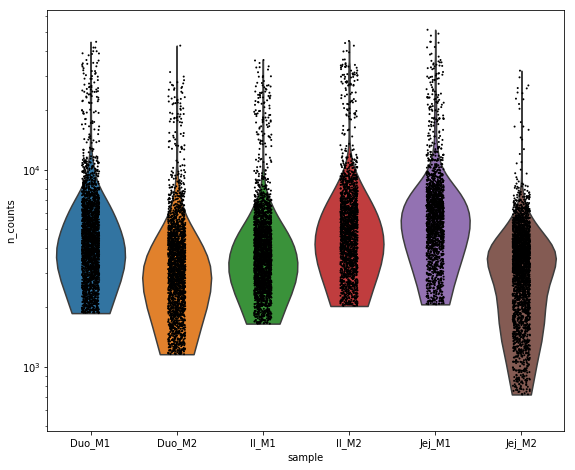

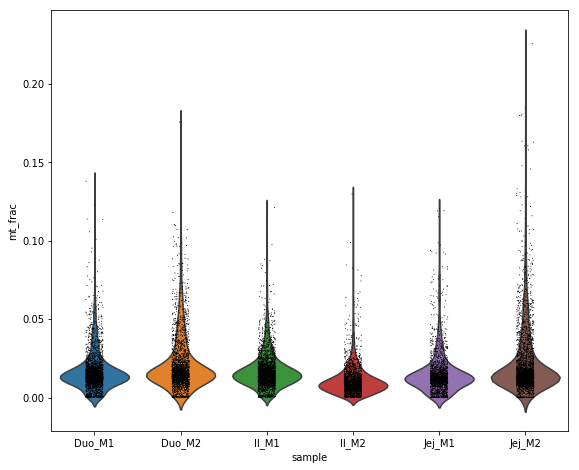

In [10]:
# Quality control - plot QC metrics
#Sample quality plots
grp_ana = 'sample' if has_samples else None
t1 = sc.pl.violin(adata, 'n_counts', groupby=grp_ana, size=2, log=True, cut=0)
if has_mt:
    t2 = sc.pl.violin(adata, 'mt_frac', groupby=grp_ana)

These plots help to assess the quality of the data. Low quality is indicated by low cell counts and large fraction of mitochondrial reads (MT frac). Typical filtering thresholds for mitochondrial reads are 20-25%. If one sample has poorer quality cells, one could perform QC filtering per sample.

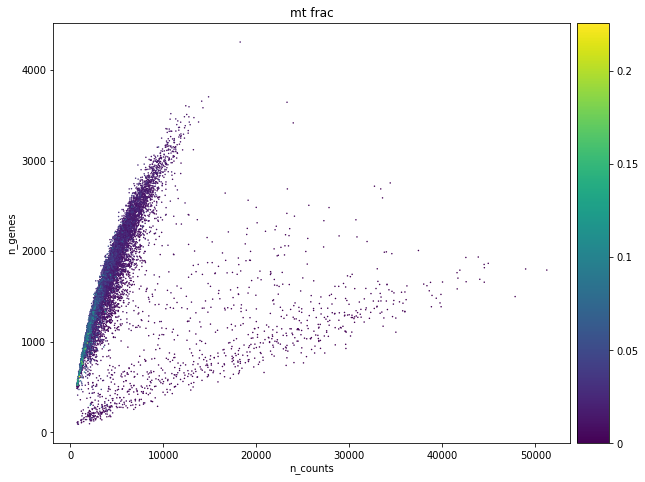

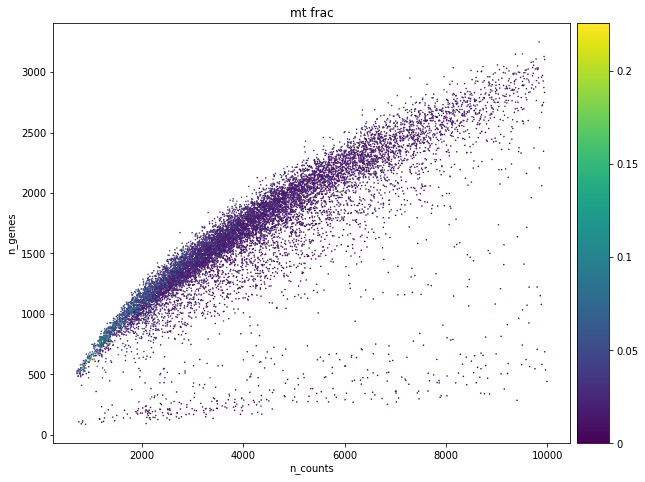

In [11]:
#Data quality summary plots
if has_mt:
    p1 = sc.pl.scatter(adata, 'n_counts', 'n_genes', color='mt_frac')
    p2 = sc.pl.scatter(adata[adata.obs['n_counts'] < 10000],
                       'n_counts',
                       'n_genes',
                       color='mt_frac')

By looking at plots of the number of genes versus the number of counts with MT fraction information, we can assess whether there are cells with unexpected summary statistics. It is important here to look at these statistics jointly. 

For example, if there is a cloud of points with many counts but few genes, our first instinct would be to filter these out as "dying" outliers. Such "dying" outliers should also be associated to high MT fractions.

Sometimes, cells with lower counts and genes tend to have higher fraction of mitochondrial counts. These cells are likely under stress or are dying. When apoptotic cells are sequenced, there is less mRNA to be captured in the nucleus, and therefore fewer counts overall, and thus a higher fraction of counts fall upon mitochondrial RNA. If cells with high mitochondrial activity were found at higher counts/genes per cell, this would indicate biologically relevant mitochondrial activity.

### Thresholding decision: counts

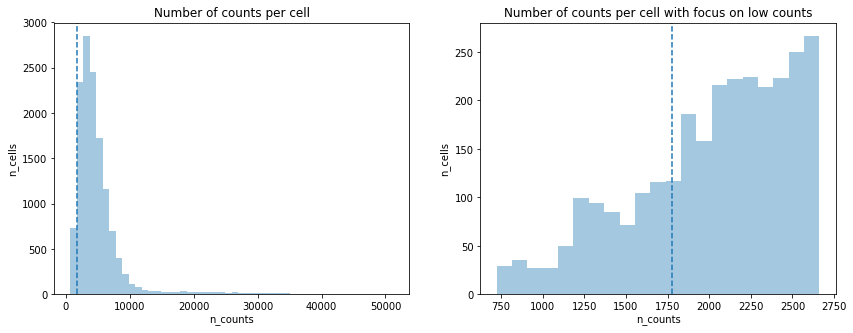

In [12]:
N = adata.obs['n_counts'].max()
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# set threshold to n_counts larger than 5th percentile
H, bins = np.histogram(adata.obs['n_counts'], bins='rice')
H = H/np.sum(H)
min_counts = max(int(bins[np.where(np.cumsum(H)>0.05)[0][0]+1]), 10)

# plot all cells
p = sns.distplot(adata.obs['n_counts'], kde=False, ax=ax[0])
p.set_title('Number of counts per cell')
p.set_ylabel('n_cells')
p.axvline(min_counts, ls='--')

# plot only low count part of histogram
p = sns.distplot(adata.obs['n_counts'][adata.obs['n_counts'] < 1.5*min_counts],
                 kde=False,
                 bins='fd',
                 ax=ax[1])
p.axvline(min_counts, ls='--')
p.set_title('Number of counts per cell with focus on low counts')
p.set_ylabel('n_cells')

plt.show()

Histograms of the number of counts per cell sometimes show peaks of groups of cells with relatively few counts (right panel). **The dashed line shows the threshold.** Such groups may be cellular debris found in droplets.

### Thresholding decision: genes

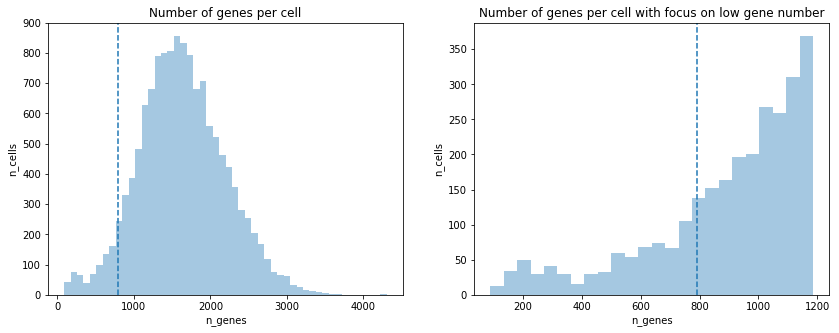

In [13]:
N = adata.obs['n_genes'].max()
fig, ax = plt.subplots(1, 2, figsize=(14, 5))

# set threshold to n_genes larger than 5th percentile
H, bins = np.histogram(adata.obs['n_genes'], bins='rice')
H = H/np.sum(H)
min_genes = max(int(bins[np.where(np.cumsum(H)>0.05)[0][0]+1]), 10)

# plot all cells
p = sns.distplot(adata.obs['n_genes'], kde=False, ax=ax[0])
p.set_title('Number of genes per cell')
p.set_ylabel('n_cells')
p.axvline(min_genes, ls='--')

# plot low gene part of histogram
p = sns.distplot(adata.obs['n_genes'][adata.obs['n_genes'] < 1.5*min_genes],
                 kde=False,
                 bins='fd',
                 ax=ax[1])
p.set_title('Number of genes per cell with focus on low gene number')
p.set_ylabel('n_cells')
p.axvline(min_genes, ls='--')

plt.show()

Sometimes, populations of cells with low gene counts can be seen in the above plots. These populations may be associated to dying cells or empty droplets with ambient RNA. **The dashed line shows the threshold.**

**Note**: In general it is a good idea to be permissive in the early filtering steps, and then come back to filter out more stringently when a clear picture is available of what would be filtered out. This is available after visualization/clustering. For demonstration purposes we stick to a simple (and slightly more stringent) filtering here.

### Filter out cells
**The parameters in this step have to be set according to the data set at hand.**

The filtering is performed based on the thresholds we identified from the QC plots (remove least 5%). Cells and genes with counts smaller than the 5th percentile and less than 10 counts absolute are removed. Genes are also filtered out if they are not detected in at least 0.5% of all cells. This reduces the dimensions of the matrix by removing 0 count genes and genes which are not sufficiently informative of the dataset. 

In [14]:
# Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_counts=min_counts)
print('Number of cells after min count filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, max_counts=40000)
print('Number of cells after max count filter: {:d}'.format(adata.n_obs))

if has_mt:
    adata = adata[adata.obs['mt_frac'] < 0.2]
    print('Number of cells after MT filter: {:d}'.format(adata.n_obs))

sc.pp.filter_cells(adata, min_genes=min_genes)
print('Number of cells after gene filter: {:d}'.format(adata.n_obs))

Total number of cells: 13353
filtered out 781 cells that haveless than 1775 counts
Number of cells after min count filter: 12572
filtered out 16 cells that havemore than 40000 counts
Number of cells after max count filter: 12556
Number of cells after MT filter: 12556
filtered out 457 cells that haveless than 791 genes expressed


Trying to set attribute `.obs` of view, making a copy.


Number of cells after gene filter: 12099


In [15]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata, min_cells=min(int(N_cells*0.005), 1))
print('Number of genes after cell filter: {:d}'.format(adata.n_vars))

Total number of genes: 27998


KeyboardInterrupt: 

<a id="Normalization"></a>

## Normalization

Up to this point the data is only available as a count matrix. Counts are representative of molecules that were captured in the scRNA-seq experiment. As not all mRNA molecules in a cell are captured, there is a variability in the total number of counts detected between cells that results from both the number of molecules that were in the cells, and the sampling. As we cannot assume that all cells contain an equal number of molecules (cell sizes can differ substantially), we have to estimate the number of molecules that were initially in the cells. In fact, we don't estimate the exact number of molecules, but instead estimate cell-specific factors that should be proportional to the true number of molecules. These are called *size factors*. Normalized expression values are calculated by dividing the measured counts by the size factor for the cell.

Based on comparisons of normalization methods for differential testing (personal communication from Beathe Vieth), and batch correction [[Buettner et al., 2019](https://www.nature.com/articles/s41592-018-0254-1)], the normalization method implemented in the scran package performs best. This method requires a coarse clustering input to improve size factor esimation performance. Thus, we use a simple preprocessing approach and cluster the data at a low resolution to get an input for the size factor estimation. The basic preprocessing includes assuming all size factors are equal (library size normalization to counts per million - CPM) and log-transforming the count data.

**NOTE: The use of PCA in the cell below introduces randomness in the result that can lead to differences in the neighborhood graph. In turn, the Louvain clustering might lead to a different cluster population and/or a different number of clusters depending on the system, where the algorithm is calculated on (even if within a docker container).**

In [ ]:
#Perform a clustering for scran normalization in clusters
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp, counts_per_cell_after=1e6)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp, n_comps=15, svd_solver='arpack')
sc.pp.neighbors(adata_pp)
sc.tl.louvain(adata_pp, key_added='groups', resolution=0.5)

In [ ]:
#Preprocess variables for scran normalization
input_groups = adata_pp.obs['groups']
data_mat = adata.X.T

In [ ]:
%%R -i data_mat -i input_groups -o size_factors

size_factors = computeSumFactors(data_mat, clusters=input_groups, min.mean=0.1)

In [ ]:
#Delete adata_pp and free memory
del adata_pp
gc.collect()

In [ ]:
# Visualize the estimated size factors
adata.obs['size_factors'] = size_factors

sc.pl.scatter(adata, 'size_factors', 'n_counts')
sc.pl.scatter(adata, 'size_factors', 'n_genes')

sns.distplot(size_factors, bins=50, kde=False)
plt.show()

We plot the size factors to show they are non-negative and related to the number of counts and genes per cell as expected.

Before normalizing the data, we ensure that a copy of the raw count data is kept in a separate AnnData object. This allows us to use methods downstream that require this data as input.

In [ ]:
#Keep the count data in a counts layer
adata.layers["counts"] = adata.X.copy()

In [ ]:
#Normalize adata
adata.X /= adata.obs['size_factors'].values[:, None]
sc.pp.log1p(adata)

In [ ]:
# Store the full data set in 'raw' as log-normalised data for statistical testing
adata.raw = adata

The count data has been normalized and log-transformed with an offset of 1. The latter is performed to normalize the data distributions. The offset of 1 ensures that zero counts map to zeros. We keep this data in the '.raw' part of the AnnData object as it will be used to visualize gene expression and perform statistical tests such as computing marker genes for clusters.

<a id="Batch"></a>

## Batch Correction

**Depending on the data set at hand, the user may need to apply batch correction.**

For the test dataset (Haber et al., 2017), batch correction is performed to adjust for batch effects from the 6 samples that were loaded. As the batch effect from samples and from epithelium regions are overlapping, correcting for this batch effect will also partially regress out differences between regions. We allow for this to optimally cluster the data. This approach can also be helpful to find differentiation trajectories, but we revert back to non-batch-corrected data for differential testing and computing marker genes.

Note that ComBat batch correction requires a dense matrix format as input (which is already the case in this example).

In [ ]:
# ComBat batch correction
if has_samples:
    sc.pp.combat(adata, key='sample')

Note ComBat batch correction can produce negative expression values. One can either set all negative values to 0 or force zeros pre-batch-correction to remain zero post-batch-correction. For simplicity we opt not to do this here.

## Highly Variable Genes<a id="HVG"></a>

We extract highly variable genes (HVGs) to further reduce the dimensionality of the dataset and include only the most informative genes. Genes that vary substantially across the dataset are informative of the underlying biological variation in the data. As we only want to capture biological variation in these genes, we select highly variable genes after normalization and batch correction. HVGs are used for clustering, trajectory inference, and dimensionality reduction/visualization, while the full data set is used for computing marker genes, differential testing, cell cycle scoring, and visualizing expression values on the data.

Here we use a standard technique for the extraction of highly variable genes from the 10X genomics preprocessing software CellRanger. Typically between 1000 and 5000 genes are selected. Here, we extract the top 20% most variable genes for further processing. If particular genes of importance are known, one could assess how many highly variable genes are necessary to include all, or the majority, of these.

In [ ]:
n_top_genes = min(int(N_genes/5), 5000)
sc.pp.highly_variable_genes(adata, flavor='cell_ranger', n_top_genes=n_top_genes)
print('\n', 'Number of highly variable genes: {:d}'.format(
        np.sum(adata.var['highly_variable'])))

In [ ]:
sc.pl.highly_variable_genes(adata)

The plots show how the data was normalized to select highly variable genes irrespective of the mean expression of the genes. This is achieved by using the index of dispersion which divides by mean expression, and subsequently binning the data by mean expression and selecting the most variable genes within each bin.

Highly variable gene information is stored automatically in the `adata.var['highly_variable']` field. The dataset now contains:
- a 'counts' layer with count data
- log-normalized data in adata.raw
- batch corrected data in adata.X
- highly variable gene annotations in `adata.var['highly_variable']`

The HVG labels will be used to subselect genes for clustering and trajectory analysis.

## Visualization<a id="Visualization"></a>

Visualizing scRNA-seq data is the process of projecting a high-dimensional matrix of cells and genes into a few coordinates such that every cell is meaningfully represented in a two-dimensional graph. However, the visualization of scRNA-seq data is an active area of research and each method defines 'meaningful' in its own way. Thus, it is a good idea to look at several visualizations and decide which visualization best represents the aspect of the data that is being investigated. 

Overall t-SNE visualizations have been very popular in the community, however the recent UMAP algorithm has been shown to better represent the topology of the data.

Note that we do not scale the genes to have zero mean and unit variance. A lack of rescaling is equivalent to giving genes with a higher mean expression a higher weight in dimensionality reduction (despite correcting for mean offsets in PCA, due to the mean-variance relationship). We argue that this weighting based on mean expression being a biologically relevant signal. However, rescaling HVG expression is also common, and the number of publications that use this approach suggests that scaling is at least not detrimental to downstream scRNA-seq analysis.

In [ ]:
# Calculate the visualizations
sc.pp.pca(adata, n_comps=50, use_highly_variable=True, svd_solver='arpack')
sc.pp.neighbors(adata)

sc.tl.tsne(adata, n_jobs=12) #Note n_jobs works for MulticoreTSNE, but not regular implementation)
sc.tl.umap(adata)
sc.tl.diffmap(adata)
sc.tl.draw_graph(adata)

In [ ]:
sc.pl.pca_scatter(adata,
                  color='n_counts',
                  components=['1,2', '1,3'],
                  title=['Redimensionalization with PCA'] * 2)

In [ ]:
sc.pl.tsne(adata, color='n_counts', title='Redimensionalization with t-SNE')

In [ ]:
sc.pl.umap(adata, color='n_counts', title='Redimensionalization with UMAP')

In [ ]:
sc.pl.diffmap(adata,
              color='n_counts',
              components=['1,2', '1,3'],
              title=['Redimensionalization with Diffusion maps'] * 2)

In [ ]:
sc.pl.draw_graph(adata,
                 color='n_counts',
                 title='Redimensionalization with ForceAtlas2')

The strengths and weaknesses of the visualizations can readily be identified in the above plots. While t-SNE exaggerates differences, diffusion maps exaggerate transitions. Overall UMAP and force-directed graph drawings show the best compromise of the two aspects, however UMAP is much faster to compute. UMAP has furthermore been shown to more accurately display the structure in the data.

<a id="CC"></a>

## Cell cycle scoring

Known sources of technical variation in the data have been investigated and corrected for (e.g. batch, count depth). A known source of biological variation that can explain the data is the cell cycle. Here, a gene list from Macosko et al., Cell 161 (2015) is used to score the cell cycle effect in the data and classify cells by cell cycle phase. The file can be found on the [single-cell-tutorial github repository](https://github.com/theislab/single-cell-tutorial), or be taken from the supplementary material of [Luecken and Theis, 2019](https://www.embopress.org/doi/10.15252/msb.20188746).

Please note, that the gene list was generated for human HeLa cells, the gene names are put into lower case with a leading capital letter to map to the respective mouse genes. When adapting this script to your own data, this must be taken into account for data from species other than mouse.

We perform cell cycle scoring on the full batch-corrected data set in adata.

In [ ]:
#Score cell cycle and visualize the effect:
cc_genes = pd.read_table('https://raw.githubusercontent.com/theislab/single-cell-tutorial/master/Macosko_cell_cycle_genes.txt', delimiter='\t')
s_genes = cc_genes['S'].dropna()
g2m_genes = cc_genes['G2.M'].dropna()

s_genes_mm = [gene.lower().capitalize() for gene in s_genes]
g2m_genes_mm = [gene.lower().capitalize() for gene in g2m_genes]

s_genes_mm_ens = adata.var_names[np.in1d(adata.var_names, s_genes_mm)]
g2m_genes_mm_ens = adata.var_names[np.in1d(adata.var_names, g2m_genes_mm)]

try:
    sc.tl.score_genes_cell_cycle(adata,
                                 s_genes=s_genes_mm_ens,
                                 g2m_genes=g2m_genes_mm_ens)
    sc.pl.umap(adata, color=['S_score', 'G2M_score'], use_raw=False)
    sc.pl.umap(adata, color='phase', use_raw=False)
except:
    print('Warning: Could not perform cell cycle scoring.')

Cell cycle scoring may show a pronounced proliferation signal in the Umap representation of the data and may suggest a proliferation phenotype in the associated cells.

<a id="Downstream"></a>

# Downstream analysis

## Clustering<a id="Clustering"></a>

Clustering is a central component of the scRNA-seq analysis pipeline. To understand the data, we must identify cell types and states present. The first step of doing so is clustering. Performing Modularity optimization by Louvain community detection on the k-nearest-neighbour graph of cells has become an established practice in scRNA-seq analysis.

Here, we perform clustering at two resolutions. Investigating several resolutions allows us to select a clustering that appears to capture the main clusters in the visualization and can provide a good baseline for further subclustering of the data to identify more specific substructure.

Clustering is performed on the highly variable gene data, dimensionality reduced by PCA, and embedded into a KNN graph. (see `sc.pp.pca()` and `sc.pp.neighbors()` functions used in the visualization section. **Note that PCA introduces randomness in the data.**

Modularity optimization via louvain has a stochastic element to it. This stochasticity typically does not affect the biological interpretation of the data, but can change the details of analysis scripts. Normally scanpy fixes the random seed to 0 to make scripts exactly reproducible. Regarding the stochasticity, the best approach would be a consensus clustering across many random seeds.

In [ ]:
# Perform clustering - using highly variable genes
sc.tl.louvain(adata, resolution=1., key_added='louvain_r1')
sc.tl.louvain(adata, resolution=0.5, key_added='louvain_r0.5')

In [ ]:
adata.obs['louvain_r0.5'].value_counts()

In [ ]:
#Visualize the clustering and how this is reflected by different technical covariates
sc.pl.umap(adata,
           color=['louvain_r1', 'louvain_r0.5'],
           palette=sc.pl.palettes.default_64)

colormap = ['n_counts', 'log_counts']
if has_mt:
    colormap.append('mt_frac')

sc.pl.umap(adata, color=colormap)

<a id="Markers"></a>

## Marker genes & cluster annotation

To annotate the clusters we obtained, we find genes that are up-regulated in the cluster compared to all other clusters (marker genes). This differential expression test is performed by a Welch t-test with overestimated variance to be conservative. This is the default in scanpy. The test is automatically performed on the `.raw` data set, which is uncorrected and contains all genes. All genes are taken into account, as any gene may be an informative marker.

If there is only one reference atlas to annotate the cells, it is not necessary to use *scmap* [[Kiselev et al., 2018](https://www.nature.com/articles/nmeth.4644)] or *Garnett* [[Pliner et al., 2019](https://www.biorxiv.org/content/10.1101/538652v1)].

In [ ]:
#Calculate marker genes
sc.tl.rank_genes_groups(adata,
                        groupby='louvain_r0.5',
                        key_added='rank_genes_r0.5')

In [ ]:
#Plot marker genes
sc.pl.rank_genes_groups(adata, key='rank_genes_r0.5', ncols=2)

The marker gene plots may help to identify clusters that are characterized by high expression of mitochondrial genes. Together with the low counts this suggests a 'stressed' phenotype.

To further identify the clusters, one may look at the overlap with a list of known marker genes. In practice marker gene sets can be obtained from public databases such as Linnarson's mouse brain atlas, various Human Cell Atlas datasets, and other published reference atlases. It should be noted that marker genes may not always overlap as expected given that atlases tend to be investigated under wild-type conditions.

**Get potential marker genes from CellMarker**

In order to have a more generalized notebook, we here download a public hand-curated list of marker genes (Zhang et al. *CellMarker: a manually curated resource of cell markers in human and mouse*, Nucleic Acids Research, Volume 47, Issue D1, 08 January 2019, Pages D721–D728, https://doi.org/10.1093/nar/gky900).

In [ ]:
!wget http://biocc.hrbmu.edu.cn/CellMarker/download/all_cell_markers.txt

In [ ]:
df_cell_marker = pd.read_table('all_cell_markers.txt')
marker_genes = dict()
for index, row in df_cell_marker.iterrows():
    marker_genes[row['cellName']] = str(row['geneSymbol']).split(', ')

In [ ]:
cell_annotation = sc.tl.marker_gene_overlap(adata, marker_genes, key='rank_genes_r0.5')
cell_annotation = cell_annotation[cell_annotation.sum(axis=1) > 20]
cell_annotation

Let's plot a heatmap with dendrogram of marker genes to get an idea, which cells can be clustered together.

In [ ]:
cell_annotation_norm = sc.tl.marker_gene_overlap(adata, marker_genes, key='rank_genes_r0.5', normalize='reference')
sns.clustermap(cell_annotation_norm[cell_annotation_norm.sum(axis=1)>0.1])

**Further analyses based on marker genes**

For a detailed analysis based on marker genes for the test dataset (Haber et al., 2017), we refer the user to the [single-cell-tutorial](https://github.com/theislab/single-cell-tutorial) git repository by Luecken and Theis (2019).

<a id="PAGA"></a>

## Partition-based graph abstraction

Partition-based graph abstraction (PAGA) is a method to reconcile clustering and pseudotemporal ordering. It can be applied to an entire dataset and does not assume that there are continuous trajectories connecting all clusters.

As PAGA is integrated into scanpy, we can easily run it on the entire data set. Here we run and visualize PAGA with different clustering inputs.

In [ ]:
adata.obs['louvain_r0.5'].value_counts()

In [ ]:
sc.tl.paga(adata, groups='louvain_r0.5')
sc.pl.paga_compare(adata)
sc.pl.paga(adata)

In the plot, stronger links between clusters are visualized by thicker lines. We can interpret this as transcriptional similarity between these clusters. Connections in PAGA may not only represent differentiation trajectories, but also transcriptional similarity between states. Thus, further experiments are required to confirm potential lineage trajectories obtained via PAGA or other trajectory inference methods.

We can do the same visualization on a umap layout.

In [ ]:
sc.pl.paga_compare(adata, basis='umap')

In [ ]:
fig1, ax1 = plt.subplots()
sc.pl.umap(adata, size=40, ax=ax1, show=False)
sc.pl.paga(adata,
           pos=adata.uns['paga']['pos'],
           show=False,
           node_size_scale=10,
           node_size_power=1,
           ax=ax1,
           text_kwds={'alpha': 0})
plt.show()

Implementation note:
- Note that the above plotting function only works when `sc.pl.paga_compare(adata, basis='umap')` is run before. The `sc.pl.paga_compare()` function stores the correct positions in `adata.uns['paga']['pos']` to overlay the PAGA plot with a umap representation. To overlap PAGA with other representation, you can run `sc.pl.paga_compare()` with other `basis` parameters before plotting the combined plot.

It should be noted that while an abstracted graph or an inferred trajectory can help to infer a lineage tree, experimental validation is necessary. Key driving forces in lineage specification might be lowly expressed genes and therefore neglected in the graph or even excluded in the HVG filtering.

<a id="Summary"></a>

# Summary

In this best practices preprocessing workflow, we went through the typical first steps of a scRNA-seq data analysis workflow. We started with general preprocessing steps, which included cell and gene quality control, normalization, batch correction, selection of highly variable genes, visualization, and cell cycle scoring. In these steps the overall structure of the data is explored and filtered to produce optimal downstream analysis results. With the clustering of the data and application of PAGA, we also had a glimpse of the downstream scRNA-seq analysis.

The downstream analysis applies methods to interpret the data and investigate particular parts of it. Therefore, these steps depend strongly on the dataset at hand. For a detailed example of the downstream analysis including cluster identification via marker genes, trajectory inference, identifying genes that change continuously over trajectories, inferring an abstracted graph to relate clusters and trajectory inference in one visualization, and differential expression over experimental conditions (here sampled intestinal regions), the user is referred to the [single-cell-tutorial](https://github.com/theislab/single-cell-tutorial) by [Luecken and Theis (2019)](https://www.embopress.org/doi/10.15252/msb.20188746).